In [11]:
import pandas as pd
import numpy as np
import lbsa

In [12]:
train_data= pd.read_csv(r"Corona_NLP_train.csv",nrows=2000,encoding='latin_1')
test_data=pd.read_csv(r"Corona_NLP_test.csv",nrows=2000,encoding='latin_1')


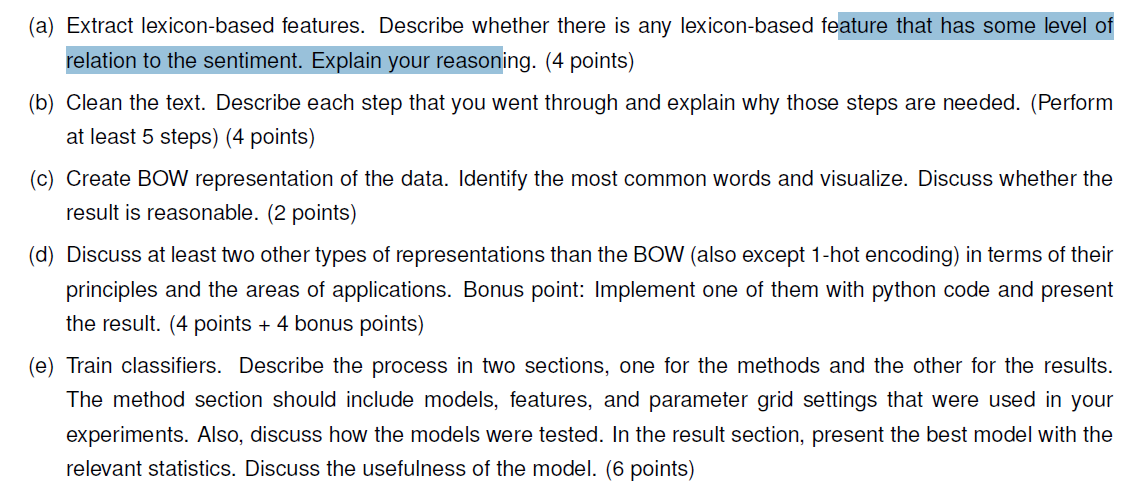

In [13]:
train_data=train_data.drop(columns=['UserName','ScreenName','Location','TweetAt'])

In [14]:
train_data['OriginalTweet'][2]

'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P'

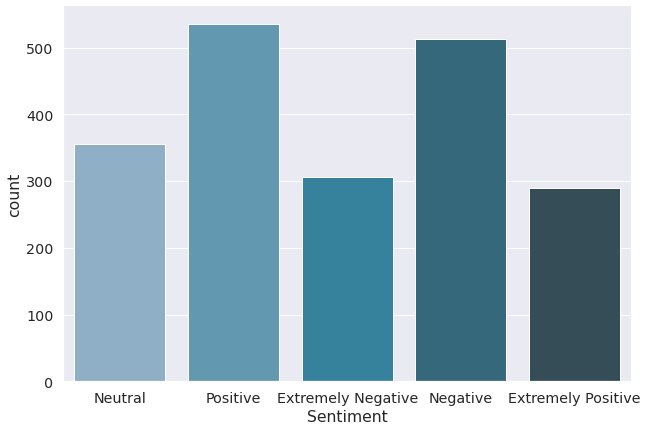

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

target_dist = sns.catplot(x='Sentiment', data=train_data, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.show()


In [16]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})

#  Extract lexicon based features

In [17]:
afinn_lexicon = lbsa.get_lexicon('opinion', language='english', source='afinn')
nrc_lexicon = lbsa.get_lexicon('opinion', language='english', source='nrc')
nrc_sa_lexicon = lbsa.get_lexicon('sa', language='english', source='nrc')
mpqa_lexicon = lbsa.get_lexicon('opinion', language='english', source='mpqa')

sa_extractor = lbsa.FeatureExtractor(afinn_lexicon, nrc_lexicon, nrc_sa_lexicon, mpqa_lexicon)
feat_dat = pd.DataFrame(sa_extractor.process(train_data['OriginalTweet']),columns=sa_extractor.feature_names)

In [18]:
import numpy as np

# def show_dist(df, col):
#     print('Descriptive stats for {}'.format(col))
#     print('-'*(len(col)+22))
#     print(df.groupby('Sentiment')[col].describe())
#     bins = np.arange(df[col].min(), df[col].max() + 1)
#     g = sns.FacetGrid(df, col='Sentiment', height=5, hue='Sentiment', palette="PuBuGn_d")
#     g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
#     plt.show()

# df_eda = pd.concat([train_data,feat_dat],axis=1)

# for feature in sa_extractor.feature_names:
#     show_dist(df_eda, feature)

#  Cleaning the text

In [19]:
pip install emoji --upgrade

Note: you may need to restart the kernel to use updated packages.


In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/uyant1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from nltk.stem import WordNetLemmatizer

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

import re, string, os, emoji

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter =  WordNetLemmatizer()
        words = input_text.split() 
        stemmed_words = [porter.lemmatize(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [23]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/uyant1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
ct = CleanText()
sent_clean = ct.fit_transform(train_data.OriginalTweet)
print(sent_clean.sample(20))
empty_clean = sent_clean == ''
print('{} records have no words left after text cleaning'.format(sent_clean[empty_clean].count()))
sent_clean.loc[empty_clean] = '[no_text]'

386     town past day struggling stock fridge essentia...
883     adding option donating item food bank whilst o...
1105    interviewed bill kelly show see podcast retail...
291     full grown as woman county highest number coro...
465     well happened tonight received message walmart...
1828    please mindful know itâs easy panic buy stock...
1969    neworleans retail business allowed stay open n...
1040    malaysia always jam whether itâs supermarket ...
551     food bank expects heightened demand change dis...
260     hello brother sister let connect hand support ...
1077    argued yesterday covid crisis not financial cr...
1685    wonder panic bought pasta donate unused supply...
1512    ya braving grocery store work today grab essen...
1120    wash hand amp touch face mindful key cell phon...
1321    great move hoping first many companyâs offer ...
713     hope no one panic buying supermarket positive ...
78      disgusting disgraceful charging inflated price...
1659    weâve

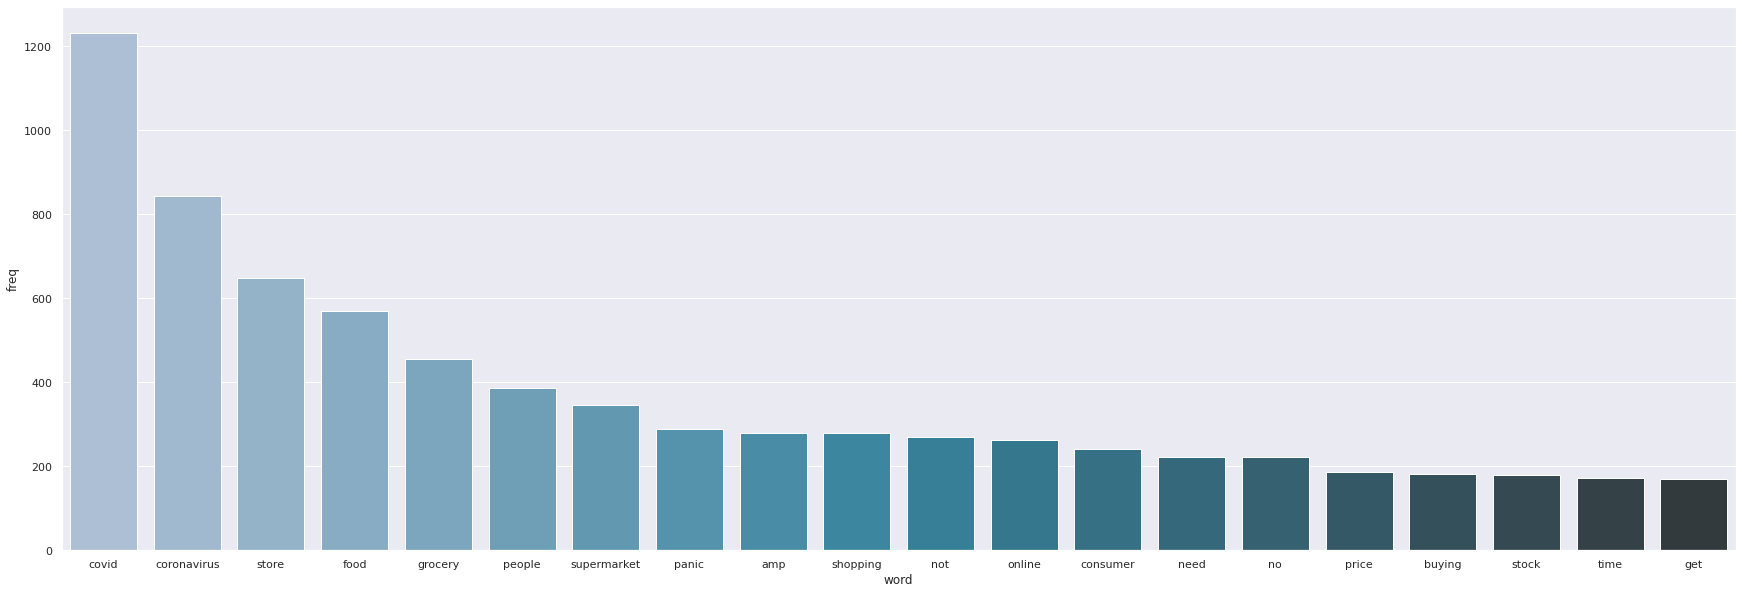

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import collections

cv = CountVectorizer()
bow = cv.fit_transform(sent_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(30, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [26]:
word_counter_df

,word,freq
0,covid,1232
1,coronavirus,843
2,store,649
3,food,570
4,grocery,456
5,people,386
6,supermarket,346
7,panic,288
8,amp,279
9,shopping,279


# Gensim 

In [56]:
from gensim.corpora.dictionary import Dictionary
from collections import Counter

In [57]:
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer

In [58]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/uyant1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [59]:
tweets=[d.split() for d in sent_clean]
tweets

[['[no_text]'],
 ['advice',
  'talk',
  'neighbour',
  'family',
  'exchange',
  'phone',
  'number',
  'create',
  'contact',
  'list',
  'phone',
  'number',
  'neighbour',
  'school',
  'employer',
  'chemist',
  'gp',
  'set',
  'online',
  'shopping',
  'account',
  'po',
  'adequate',
  'supply',
  'regular',
  'med',
  'not',
  'order'],
 ['coronavirus',
  'australia',
  'woolworth',
  'give',
  'elderly',
  'disabled',
  'dedicated',
  'shopping',
  'hour',
  'amid',
  'covid',
  'outbreak'],
 ['food',
  'stock',
  'not',
  'one',
  'empty',
  'please',
  'panic',
  'enough',
  'food',
  'everyone',
  'not',
  'take',
  'need',
  'stay',
  'calm',
  'stay',
  'safe',
  'covidfrance',
  'covid',
  'covid',
  'coronavirus',
  'confinement',
  'confinementotal',
  'confinementgeneral'],
 ['ready',
  'go',
  'supermarket',
  'covid',
  'outbreak',
  'not',
  'paranoid',
  'food',
  'stock',
  'litteraly',
  'empty',
  'coronavirus',
  'serious',
  'thing',
  'please',
  'panic',
  

In [66]:
dictionary  = Dictionary(tweets)
# Create a Dictionary from the articles: dictionary

# # Select the id for "computer": computer_id
# computer_id = dictionary.token2id.get("covid")

# # # Use computer_id with the dictionary to print the word
# print(dictionary.get(computer_id))

# # Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(a) for a in tweets]

# # # Print the first 10 word ids with their frequency counts from the fifth document
print(corpus[1][:300])


[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]


In [67]:
doc = corpus[2]

In [68]:
# Print the top 10 words of the document alongside the count,
bow_doc = sorted(doc, key=lambda w: w[1], reverse=True)
for word_id, word_count in bow_doc[:10]:
    print(dictionary.get(word_id), word_count)


shopping 1
amid 1
australia 1
coronavirus 1
covid 1
dedicated 1
disabled 1
elderly 1
give 1
hour 1


In [69]:
import itertools

In [70]:
# Create the defaultdict: total_word_count
total_word_count = collections.defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count
# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True) 

# Print the top 5 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:5]:
    print(dictionary.get(word_id), word_count)

covid 1232
coronavirus 843
store 649
food 570
grocery 455


In [71]:
from gensim.models.tfidfmodel import TfidfModel

In [72]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Calculate the tfidf weights of doc: tfidf_weights
tfidf_weights = tfidf[doc]

# Print the first five weights
print(tfidf_weights[:5])

[(23, 0.14381196526764178), (26, 0.26539947741277975), (27, 0.3727659980963391), (28, 0.06446613246877456), (29, 0.04041754665743033)]


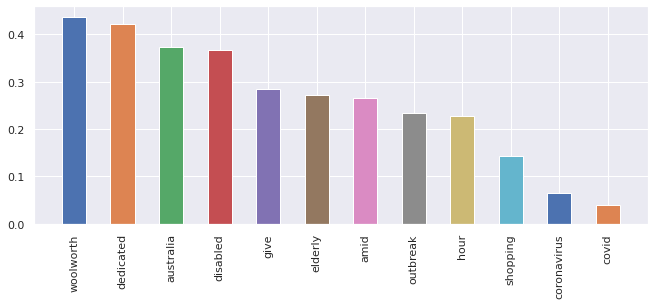

In [73]:

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
for term_id, weight in sorted_tfidf_weights[:100]:
    
    
    plt.bar(dictionary.get(term_id), weight,width = 0.5)
    plt.xticks(rotation='vertical')


In [28]:
df_model = df_eda
df_model['clean_text'] = sent_clean
df_model.columns.tolist()

['OriginalTweet',
 'Sentiment',
 'afinn_positive',
 'afinn_negative',
 'nrc_positive',
 'nrc_negative',
 'nrc_anger',
 'nrc_anticipation',
 'nrc_disgust',
 'nrc_fear',
 'nrc_joy',
 'nrc_sadness',
 'nrc_surprise',
 'nrc_trust',
 'mpqa_positive',
 'mpqa_negative',
 'mpqa_strong_subjectivty',
 'clean_text']

# model

# Logreg

In [33]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

mnb = MultinomialNB()
logreg = LogisticRegression(max_iter=10000, solver='saga')
countvect = CountVectorizer()


In [34]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('Sentiment', axis=1), df_model.Sentiment, test_size=0.1, random_state=30)

In [41]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

mnb = MultinomialNB()
logreg = LogisticRegression(max_iter=10000, solver='saga')
countvect = CountVectorizer()

In [42]:
from pprint import pprint
from time import time

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['afinn_positive', 'afinn_negative', 'nrc_positive', 'nrc_negative', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust',
                     'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust', 'mpqa_positive', 'mpqa_negative', 'mpqa_strong_subjectivty']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [43]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


In [44]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 19.6min finished


done in 1191.641s

Best CV score: 0.653
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.630


Classification Report Test Data
                    precision    recall  f1-score   support

Extremely Negative       0.81      0.68      0.74        31
Extremely Positive       0.78      0.55      0.64        33
          Negative       0.59      0.52      0.55        50
           Neutral       0.58      0.91      0.71        35
          Positive       0.56      0.57      0.56        51

          accuracy                           0.63       200
         macro avg       0.66      0.65      0.64       200
      weighted avg       0.65      0.63      0.63       200



In [49]:
logreg_test_preds = X_test.loc[:, ['OriginalTweet']]
logreg_test_preds['sentiment']=y_test
logreg_test_preds['pred']=best_logreg_countvect.predict(X_test)
logreg_test_preds

,OriginalTweet,sentiment,pred
1856,"Guess?, Inc. Provides COVID-19 Business Update...",Positive,Positive
364,Economic Perspectives - Global Inflation Persp...,Negative,Positive
1948,@NewYorker My friends in #Strasbourg #france s...,Positive,Positive
1458,9 Online Grocery Shopping Stores In Klang Vall...,Neutral,Neutral
609,@DrAmalinaBakri Saw someone shared on what kin...,Positive,Positive
...,...,...,...
1992,"@N_Mazibuk0 Let's all be accurate, there's NO ...",Extremely Negative,Extremely Negative
1942,I donÂt want to work at a grocery store anymo...,Positive,Positive
470,"Oh my God, even after coming up with a list of...",Negative,Negative
314,Shit moms.. I just got done telling my kids ho...,Positive,Positive


In [51]:
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix

In [53]:
print(confusion_matrix(y_test,best_logreg_countvect.predict(X_test)))

[[21  0  9  0  1]
 [ 0 18  1  0 14]
 [ 4  1 26 11  8]
 [ 0  1  2 32  0]
 [ 1  3  6 12 29]]
